# Classifiers 


Extract fMRI signal (from preprocessed data), and then training and testing classifiers on the brain.


## Goal of this script
Using this script you will learn to use a classifier on a dataset. Specifically, we will accomplish the following:  
>1. Assign labels to every time-point (TR) in the dataset.
>2. Time-shift the signal to be classified, taking into consideration the delayed hemodynamic response.
>3. Collect BOLD data for all runs into one array.
>4. Test out a classifier (SVM) on a group of subjects with a fixed set of parameters.
>5. Replicate the analysis that led to the modular vs. distributed processing debate.


## Table of Contents
[1. Loading and Normalization](#load_data)  
>[1.1 Experiment labels](#label_data)  
>[1.2 Plot the different conditions](#plot_boxcar)  
>[1.3 Hemodynamic lag: Time shift the labels](#label_shift)  
>[1.4 Load the fMRI data](#load_fmri)  

[2. Classification](#classification)  
>[2.1 Reshape data](#reshape)  
>[2.2 Model training](#model_training)  
>[2.3 Model testing](#model_testing)  
>[2.4 Test across participants](#across_ppts)  

[3. Modular vs Distributed Processing](#mod)
>[3.1 Prepare data](#prep)  
>[3.2 FFA](#mod_dist_ffa)  
>[3.3 PPA](#mod_dist_ppa) 

Exercises
>[Exercise 1](#ex1)  [2](#ex2)  [3](#ex3)   [4](#ex4)  [5](#ex5)   [6](#ex6)

[Novel contribution](#novel)

[Contributions](#contributions)



**Dataset** For this script we will use the localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. 

**General overview:** Localizer task where neural activation of participants was measured when presented with an image of a face, a scene, or an object. 

**Explanation:** The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Each block was presented for 15s. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the MATLAB stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial. 


In [39]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler
from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func
from brainiak.utils import fmrisim as sim

# load some helper functions
from utils import load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data 
from utils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs, vdc_hrf_lag, vdc_TR, vdc_TRs_run # load some constants

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})
sns.set(palette="colorblind")

Autosaving every 5 seconds


In [40]:
print('Here are some constants, which is specific to the VDC data:')
print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %s' % (vdc_n_runs))
print('1 TR = %.2f sec' % (vdc_TR))
print('HRF lag = %.2f sec' % (vdc_hrf_lag))
print('num TRs per run = %d' % (vdc_TRs_run))

Here are some constants, which is specific to the VDC data:
data dir = /Users/aratzan/Downloads/brainiak_datasets/vdc
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3
1 TR = 1.50 sec
HRF lag = 4.50 sec
num TRs per run = 310


In [41]:
# Directory structure of the VDC dataset
header_file=os.path.join(vdc_data_dir,'README.txt')
!head -50 $header_file

1. Data structure

my_dataset/
├── README.txt 							# This file, Contains experimental design/task details, imaging parameters, and description of the directory structure
├── DESIGN.txt 							# Descriptions of design matrixes (in design_matrix folder)
├── sub-01/								
	├── day1								# Data of the first fMRI session (day 1)
	│   ├── anat
	│   │   ├── sub-01_fieldmap_01.nii.gz		# Field map image to correct B0 inhomogeneities 
	│   │   ├── sub-01_fieldmap_02.nii.gz
	│   │   ├── sub-01_t1_flash01.nii.gz		# Fast Low Angle shot anatomical scan
	│   │   ├── sub-01_t1_mprage.nii.gz		# raw 3-D structural image (T1-weighted magnetization prepared rapid acquisition gradient-echo image)
	│   │   ├── sub-01_t2_tse_01.nii.gz		# T2-weighted turbo spin echo image for hippocampal segmentation
	│   │   └── sub-01_t2_tse_02.nii.gz		
	│   └── func
	│       ├── sub-01_study_01.nii.gz			# Raw 4-D functional image of a study phase (run 1-6)
	│       ├── sub-01_study_02.nii.gz
	│       ├── sub-01_study

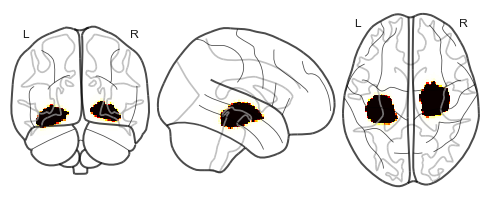

In [53]:
#access a brain image and plot it 
from nilearn import plotting

ffa_mask_s1 = '/Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/masks/sub-01_ventral_FFA_locColl_to_epi1.nii.gz'

plotting.plot_glass_brain(ffa_mask_s1)


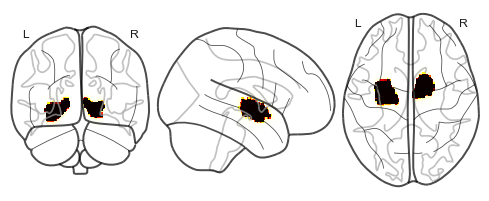

In [54]:
ppa_mask_s1 = '/Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/masks/sub-01_ventral_PPA_locColl_to_epi1.nii.gz'

plotting.plot_glass_brain(ppa_mask_s1)



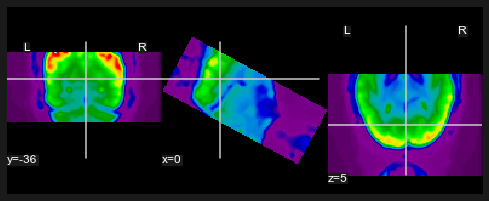

In [72]:
from nilearn.image import mean_img
from nilearn import image 

#functional bold data from subject 1 on day 2 

func_data_s1 = '/Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/ses-day2/func/sub-01_ses-day2_task-localizer_run-02_bold.nii.gz'

#have to take a mean image because data is 4D

meanEPI = mean_img(func_data_s1)
smoothMean = image.smooth_img(meanEPI, fwhm=5)
plotting.plot_epi(smoothMean) 

#shows dimensionality and size of data... doesn't take into account areas of brain that are irrelevant (???)
#MESS AROUND WITH ORIENTATION

In [66]:
# anatomical data from subject 1 on day 2 
anat_data_s1 = '/Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/ses-day2/anat/sub-01_ses-day2_T1w.nii.gz'
plotting.view_img(anat_data_s1)



## 1. Loading and Normalization<a id="load_data"></a>

Load and visualize the experiment labels and then we will load the brain data.

### 1.1 Experiment labels <a id="label_data"></a>

In [5]:
sub = 'sub-01';

# function for loading in the labels
def load_vdc_stim_labels(vdc_data_dir, subject_id):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1, vdc_n_runs+1):
        in_file = os.path.join(vdc_data_dir,subject_id,'ses-day2','design_matrix','%s_localizer_0%d.mat' % 
                               (subject_id, run))
        # Load in data from MATLAB
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))
    print("Loaded labels for", subject_id)
    return stim_label_concatenated

# Note: you won't see the printed "Loaded labels for..." until you run the function with inputs (see next step)

We now want to call this function and get its outputs.

In [6]:
# Load in the labels of the data
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir, sub)

Loaded labels for sub-01


We need category labels to train a classifier for every timepoint in the fMRI data. These timepoints are referred to as TRs.

This subject has 310 TRs but all others have 311 (no good reason, just a quirk of the dataset). Some TRs will not have a label since there was no stimulus presented (e.g., the fixation periods between blocks). 

Recall that the third row of the timing file is the start time of a trial in seconds since the start of the run. We can thus convert each time stamp to a specific TR by taking that time stamp and dividing by the TR duration (1.5 s). 

Function to return a list of category labels, one for each TR in chronological order: 

In [7]:
# Define the function

def label2TR(all_stim_labels, num_runs, TR, TRs_run):
    
    stim_label_TR = np.zeros((TRs_run * 3, 1))
    
    _, events = all_stim_labels.shape
    events_run = int(events / num_runs)
    
    for run in range(num_runs): #run 0, 1, 2
    # Cycle through each element in a run
        for i in range(events_run):
            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i 
            
            # What is the time stamp
            time = all_stim_labels[2, time_idx] #row 3, col...; ends up indexing out of bounds

            # What TR does this timepoint refer to?
            TR_idx = int(time / TR) + (run * (TRs_run - 1)) #TR num

            # Add the condition label to this timepoint
            stim_label_TR[TR_idx] = all_stim_labels[0, time_idx]
            
    return stim_label_TR
    
    
    

Run the function and check that it works

In [8]:
# Run function
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, vdc_TRs_run)

#labels for each TR in all runs

###  1.3 Hemodynamic lag: Time shift the labels <a id="label_shift"></a>

The BOLD response that we measure with fMRI is slow to emerge after the onset of a stimulus, also known as the "hemodynamic lag". Below we plot the expected BOLD response to a single experimental event.

**1.3.2 Time shift the VDC labels**  
It takes approximately 4-6s for the BOLD response to peak after an event. Hence the brain's activity does not reflect what is occuring in the world currently, but rather what occurred in the recent past. To account for the hemodynamic lag, we can shift the timecourse of labels such that they correspond in time with the future brain response they produce. First let's plot this timecourse.

Text(0.5, 0, 'Time (seconds)')

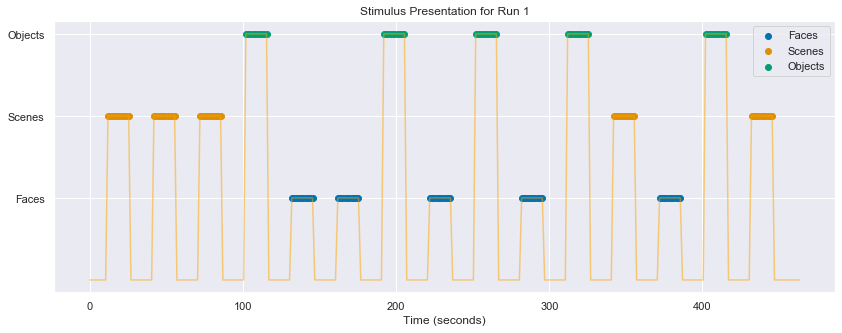

In [9]:
n_conditions = len(vdc_label_dict)
cur_pals = sns.color_palette('colorblind', n_colors=n_conditions)

# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (vdc_TRs_run - 1) * 1.5 + 1, 1.5)
time_vals = stim_label_allruns[2, 0:150]
labels = stim_label_allruns[0, 0:150]

f, ax = plt.subplots(1,1, figsize = (14, 5))
    
# plot the label for each condition
for i_cond in range(n_conditions): 
    label = list(vdc_label_dict.keys())[i_cond]
    temp_mask = label == labels
    ax.scatter(time_vals[temp_mask], labels[temp_mask], 
               color = cur_pals[i_cond], marker = 'o')
ax.legend(vdc_label_dict.values())
    
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time (seconds)')


We need to incorporate this time-shift when we extract the BOLD signal for classification (so that the labels apply to the correct brain images). One way to accomplish this is to shift the labels and extract the BOLD signal for the non-zero labels. Given that one TR = 1.5 s and the typical hemodynamic lag is 4-5 s, we will shift the labels forwards by 3 TRs.

In [10]:
# Shift the data a certain amount
print('Amount of time shift: %0.1f' % vdc_hrf_lag) # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(vdc_hrf_lag / vdc_TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

Amount of time shift: 4.5


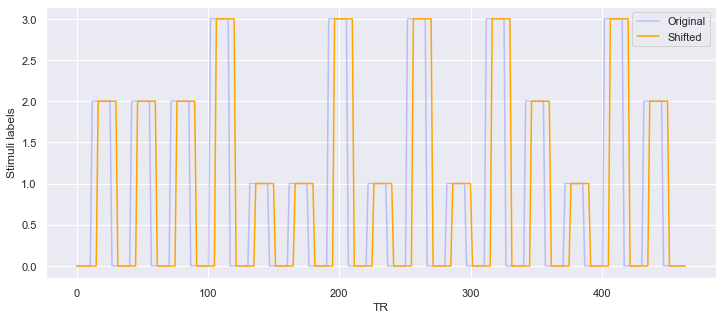

In [11]:
#boxcar plot with hemodynamic lag incorporated 
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:vdc_TRs_run, 0], c='blue',alpha=0.2)
ax.plot(tr_time, stim_label_TR_shifted[0:310], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('TR')

plt.legend(['Original', 'Shifted'])

### 1.4 Load the fMRI data<a id="load_fmri"></a>

Load in, mask, and z-score the fMRI data. This time we are going to load in all participants, so this may take a while.

In [12]:
''' Regions of interests to focus on are Fusiform Face Area (FFA) and Parahippocampal Place Area (PPA)'''
print('available ROIs: ', vdc_all_ROIs)

available ROIs:  ['FFA', 'PPA']


In [13]:
roi_name = 'FFA'

# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Check the dimensionality of the data
print('voxel by TR matrix - shape: ', epi_mask_data_all[vdc_all_ROIs.index(roi_name)].shape)
print('label list - shape: ', stim_label_TR_shifted.shape)

Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
voxel by TR matrix - shape:  (5519, 930)
label list - shape:  (930,)


In [14]:
#what loading the data does

help(load_vdc_masked_data)

Help on function load_vdc_masked_data in module utils:

load_vdc_masked_data(directory, subject_name, mask_list)
    # Make a function to load the mask data



## 2. Classification<a id="classification"></a>

Basic classifier to categorize data. 

For brain activity measured by fMRI, the voxel signals serve as the features. If we were showing pictures of faces, scenes, and objects, and collecting fMRI data while the subject was viewing the pictures, we know what picture were shown at each time-point. The stimulus type at each timepoint serves as the stimulus label. The signal from voxels at each timepoint correspond to the features of that picture. From this known set of stimulus labels and features, we can train a classifier to distinguish between pictures of faces, scenes, and objects.

If the classifier makes predictions above chance (random guessing will lead to a 33.33% accuracy for 3 categories), the classifier has read out from the brain the category of the stimulus.

SVM classifier, hard-coded hyperparameters

### 2.1 Reshape data <a id="reshape"></a>

First, we extract the time points for which we have stimulus labels (only Faces, Places, and Objects). That is, we drop the time-points from the BOLD signal that refer to the fixation periods.

In [15]:
# Extract bold data for non-zero labels
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index] 
    return indexed_data, nonzero_labels #indices and corresponding labels 

# Pull out the data from this ROI for these time points
roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data) #cleans up data and labels

# What is the dimensionality of the data? We need the first dim to be the same
print('The %s has the dimensionality of: %d time points by %d voxels' % (roi_name, bold_data.shape[0], bold_data.shape[1]))

The FFA has the dimensionality of: 450 time points by 5519 voxels


### 2.2 Leave-One-Run-Out (LORO) training and testing  <a id="model_training"></a>

Perform LORO cross-validation to train and test. Can do folds of each run. 

**other types of cross-validation can also be used**

#### 2.2.1. Manually create a left-out run.

In [16]:
# Get run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1 

# Select a run
holdout_run_ids = 0

# Make an index list with one run left out.
train_runs = run_ids != holdout_run_ids

print(run_ids)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

**2.2.2 Normalization**

Reduce variance and bias through normalization. 


In [17]:
def normalize(bold_data_, run_ids):
    """normalized the data within each run
    
    Parameters
    --------------
    bold_data_: np.array, n_stimuli x n_voxels
    run_ids: np.array or a list
    
    Return
    --------------
    normalized_data
    """
    scaler = StandardScaler()
    data = []
    for r in range(vdc_n_runs):
        data.append(scaler.fit_transform(bold_data_[run_ids == r, :]))
    normalized_data = np.vstack(data)
    return normalized_data

In [18]:
bold_data_normalized = normalize(bold_data, run_ids)

### 2.3. Classifiers

Use a linear [support vector machine (SVM)](https://scikit-learn.org/stable/modules/svm.html). It is one of the most commonly used classifiers in cognitive neuroscience as it is robust to low number of training samples and outliers in the data.


In [19]:
# Split the training set and test set ... 
X_train = bold_data_normalized[train_runs,]
y_train = labels[train_runs]
#logical_not only uses holdout run
X_test = bold_data_normalized[np.logical_not(train_runs),] 
y_test = labels[np.logical_not(train_runs)]

print(X_train)

[[ 0.27636606 -2.34144    -1.5168508  ... -1.2768594  -0.5333573
  -0.39660725]
 [ 1.1786194   0.6995016  -0.20767328 ...  0.8843117   0.89988357
   1.32755   ]
 [ 0.5377398  -1.5607868  -0.5580817  ... -1.5061353  -2.6355433
   0.1930118 ]
 ...
 [ 0.13409585 -0.15990087 -0.4277773  ... -1.4076195  -1.0346426
  -1.6303952 ]
 [ 0.57703644 -0.15957198 -0.11492413 ... -0.11137345 -0.6525026
  -0.40301976]
 [-1.1678511   1.3851509  -0.19576998 ... -0.7032622  -0.6667949
  -0.21055813]]


#### 2.3.1. Build a classifier and test on the held out run.

The `X_train` data was created by excluding one run. We use this to train a classifier and then test it on `X_test`, the dataset that was created from the held-out run.

In [20]:
# Create a classifier model for the training set 
model = LinearSVC(C=1)

# Fit the model
model.fit(X_train, y_train)

# Compute your evaluation on the test set
score = model.score(X_test, y_test)
print('Accuracy = %s' % score)

Accuracy = 0.88


#### 2.3.2. Build a classifier by training and testing on multiple folds.

The `PredefinedSplit` method does this automatically. Use PredefinedSplit to split the data for LORO multiple folds. 


In [21]:
# loop over all runs 
scores = []

# split data according to run ids 
ps = PredefinedSplit(run_ids)

# classifier 
model = LinearSVC() 
for train_index, test_index in ps.split():
    X_train, X_test = bold_data_normalized[train_index], bold_data_normalized[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    # fit an svm
    model.fit(X_train, y_train)
    
    # calculate the accuracy for the hold out run
    score = model.score(X_test, y_test)
    scores.append(score)
    
print('Accuracy across folds:', scores)

Accuracy across folds: [0.88, 0.8933333333333333, 0.8466666666666667]


**2.3.3 Classifier Performance**  

In the VDC dataset, we have 3 equally represented sets of stimuli, and thus random guessing will result in being correct 1/3 of the time. Using this logic, this classifier used fMRI data from a brain mask of the Fusiform Face Area to make highly statistically significant classifications on a single participant. 

### 2.4 Perform the analysis on multiple  participants <a id="across_ppts"></a>

The next step is to run a classifier on a group of subjects. We will now create the condition variable, stim_label_TR, for all subjects and then use it to pull out the relevant participant data and then feed it into a classifier.

Before you run this command, make sure you save your notebook. You will be loading in a lot of data and so it might run into memory issues and crash your job. If you do have issues, change how many cores/memory you are using when you launch this notebook.

**Exercise 2:**<a id="ex2"></a> Convert the classifier code above into a function called `decode` with the inputs of data, labels, and run_labels.

In [22]:
# Put code here. The function should output models and scores
def decode(data, labels, run_labels): 
    #data is normalized BOLD data from each subject 
    #labels is stimulus being shown
    
    score = model.score(data, labels)
    #run labels is run number 
    
    return model, score

Run the function on this participant

In [23]:
# Run the function 

#bold_data_normalized should take data from ALL subjects, store in 1 massive array
#just do by combining the three subjects 

models, scores = decode(bold_data_normalized, labels, run_ids)
print('Decoding accuracy across the 3 folds: ', scores)

Decoding accuracy across the 3 folds:  0.9488888888888889


**Exercise 3:** <a id="ex3"></a> What is the average SVM accuracy for sub-01, sub-02 and sub-03?

In [23]:
#find the accuracy of a classifier across participants
subs = ['sub-01', 'sub-02', 'sub-03']

roi_name = 'FFA'

#load in the data for each subject 
masked_data_sub_01 = load_vdc_masked_data(vdc_data_dir, 'sub-01', vdc_all_ROIs)
FFA_masked_data_01 = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data_01, labels_01 = reshape_data(stim_label_TR_shifted, roi_masked_data)

masked_data_sub_02 = load_vdc_masked_data(vdc_data_dir, 'sub-02', vdc_all_ROIs)
FFA_masked_data_02 = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data_02, labels_02 = reshape_data(stim_label_TR_shifted, roi_masked_data)

masked_data_sub_03 = load_vdc_masked_data(vdc_data_dir, 'sub-03', vdc_all_ROIs)
FFA_masked_data_03 = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data_03, labels_03 = reshape_data(stim_label_TR_shifted, roi_masked_data)




Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-02/preprocessed/loc/sub-02_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Us

In [24]:
print("labels", np.shape(labels_01))
print("data", np.shape(bold_data_01))
#np.shape(labels_02)
print("labels", np.shape(labels_02))
print("data", np.shape(bold_data_02))
print("labels", np.shape(labels_03))
print("data", np.shape(bold_data_03))

#all the same size so just concatenate.
all_labels = np.concatenate((labels_01, labels_02, labels_03), axis = 0)
all_bold_data = np.concatenate((bold_data_01, bold_data_02, bold_data_03), axis = 0)
print(np.shape(all_labels))
print(all_labels)
print(np.shape(all_bold_data))
print(all_bold_data)

labels (450,)
data (450, 5519)
labels (450,)
data (450, 5519)
labels (450,)
data (450, 5519)
(1350,)
[2. 2. 2. ... 2. 2. 2.]
(1350, 5519)
[[14431.849 14724.007 13766.936 ... 12111.685 12827.976 11162.897]
 [14229.876 14711.505 13581.832 ... 12205.481 12657.786 11434.864]
 [14264.533 14252.69  13182.161 ... 12244.312 13076.692 11114.171]
 ...
 [14349.139 14398.849 13002.225 ... 12546.632 12952.056 11063.763]
 [14416.948 14398.909 13061.412 ... 12778.975 13024.539 11242.5  ]
 [14149.824 14683.279 13046.117 ... 12672.883 13021.828 11270.527]]


In [25]:
#perform a train test split 
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
all_bold_data_normalized = scaler.fit_transform(all_bold_data)

X_train, X_test, y_train, y_test = train_test_split(all_bold_data_normalized, all_labels, test_size = 0.33)


In [26]:
full_model = LinearSVC(C=1)

# Fit the model
full_model.fit(X_train, y_train)

# Compute your evaluation on the test set
score = full_model.score(X_test, y_test)

print(score)

1.0


In [2]:
#EXPLANATION
''' The reason the above classification score is so high is due to the fact that it was trained
on all the participants. Considering the classifier had seen fMRI data of all the subjects, this
is practically double dipping (classifiying data it has already seen). Similar to leaving out 
a run as done before let's train the classifier on 2 participants and see how it does when presented
with data from a new participant. '''

#should try and extrapolate to a new participant 


" The reason the above classification score is so high is due to the fact that it was trained\non all the participants. Considering the classifier had seen fMRI data of all the subjects, this\nis practically double dipping (classifiying data it has already seen). Similar to leaving out \na run as done before let's train the classifier on 2 participants and see how it does when presented\nwith data from a new participant. "

In [3]:
'''Create an SVC model trained on data from participants 1 and 2 
and test on participant 3 '''

# Step 1. Create an array of bold data from participants 1 and 2 

# Step 2. Create an array of labels of this corresponding data

# Step 3. Normalize bold data of training data array from participants 1 and 2 using StandardScaler

# Step 4. Normalize bold data of participant 3 

# Step 5. Train SVC on normalized bold data of first 2 participants

# Step 6. Test SVC model on participant 3 

'Create an SVC model trained on data from participants 1 and 2 \nand test on participant 3 '

In [23]:
# Insert code here
subs = ['sub-01', 'sub-02', 'sub-03']

print(vdc_n_runs) #3 runs

for sub in subs:
    roi_name = 'FFA'
    # Apply the function to pull out the mask data
    epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)
    roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
    bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data)
    run_ids = stim_label_allruns[5, :] - 1
    print(run_ids)
    print(bold_data.shape)
    bold_data_normalized = normalize(bold_data, run_ids)
    models, scores = decode(bold_data_normalized[:,:5519], labels, run_ids)
    print(models, scores)
    
    #don't have to train on classifier, 
    #simply normalize data, get necessary variables and test  
    
    

3
Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 

In [166]:
models, scores = decode(bold_data_normalized[:,-5519:], labels, run_ids)
print(models, scores)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.3622222222222222


In [163]:
sub = 'sub-03'
roi_name = 'FFA'
# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)
roi_masked_data = epi_mask_data_all[vdc_all_ROIs.index(roi_name)]
bold_data, labels = reshape_data(stim_label_TR_shifted, roi_masked_data)
run_ids = stim_label_allruns[5, :] - 1
print(run_ids)
print(bold_data.shape)
bold_data_normalized = normalize(bold_data, run_ids)
models, scores = decode(bold_data_normalized[:,-5519:], labels, run_ids)
print(models, scores)


Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-03/preprocessed/loc/sub-03_filtered2_d1_firstExampleFunc_r3.nii
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.

In [164]:
models, scores = decode(bold_data_normalized[:,-5519:], labels, run_ids)
print(models, scores)

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) 0.3622222222222222


In [151]:
print(bold_data_normalized.shape) #450 x 7027 

(450, 7027)


## 3. Modular vs. Distributed Processing <a id="mod"></a>

The discovery of the Fusiform Face Area (FFA; Kanwisher, McDermott, and Chun, 1997; see also McCarthy, Puce, Gore, & Allison, 1997) was ground breaking for the field. The mean activity signal for face stimuli was larger than the mean for houses and objects. Thus, the FFA was preferential to faces, and by extension, it was inferred that all other cognitive processing must also be localized in brain regions yet to be discovered. 

The local nature of processing was challenged by another study (Haxby et al., 2001). Instead of looking at the mean activity of a set of voxels, this study examined the _pattern of activity_ of a set of voxels. Thus, if the mean activity was similar for two conditions, but the pattern of activity across a set of voxels was different across the two conditions, we can discriminate between the two conditions. Using this technique, it was shown that faces are not represented just in the FFA alone, but are distributed across a variety of brain regions. This led to the distributed view of face processing.

In this section, you will perform a decoding analysis in the FFA and the parahippocampal place area (PPA) using the VDC dataset. To recap, the FFA was shown as a face processing region and the PPA as a scene processing region. Specifically, you will analyze the patterns of activity in these ROIs in the following ways: 

>1. Can we discriminate scenes vs. objects in the FFA?  
      The FFA was shown to be a preferred region for face processing. If we can decode scenes vs. objects in this region, it implies that there is discriminable information for these two categories in the FFA. Thus, the FFA would not just represent faces, but scenes and/or objects too. Also, scenes would not be exclusively represented in the PPA. 
           
>2. Can we discriminate faces vs. objects in the PPA?  
      The PPA was shown to be a preferred region for scene processing. If we can decode faces vs. objects in this region, it implies that there is discriminable information for these two categories in the PPA. Thus, faces would not only be represented in the FFA. Also, the PPA would not just represent scenes, but faces and/or objects too.
      

### 3.1. Prepare the data for loading <a id="prep"></a>

Get the data ready for analysis of one participant by organizing it by ROI

In [24]:
# choose a subject
sub = 'sub-01';

# Convert the shift from secs to TRs
shift_size = int(vdc_hrf_lag / vdc_TR) 

# Load subject labels
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir,sub) 

# Load the fMRI data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Convert the timing into TR indexes
TRs_run = int(epi_mask_data_all[0].shape[1] / vdc_n_runs)
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, vdc_TR, TRs_run)

# Shift the data some amount
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

# Select and reshape FFA data 
bold_data_FFA, labels = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('FFA')])

# Select and reshape PPA data 
bold_data_PPA, _ = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('PPA')])

# Specify the classifiers that will be used
svc = LinearSVC()

# load run ids (works similarity to cv_ids)
run_ids = stim_label_allruns[5,:] - 1 

Loaded labels for sub-01
Loaded FFA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii
Loaded PPA mask
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r1.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r2.nii
Loading data from /Users/aratzan/Downloads/brainiak_datasets/vdc/sub-01/preprocessed/loc/sub-01_filtered2_d1_firstExampleFunc_r3.nii


### 3.2 Decoding the Fusiform Face Area (FFA)<a id="mod_dist_ffa"></a>

**Exercise 4:**<a id="ex4"></a> Decode Objects vs. Scenes from the FFA and report mean LORO test accuracy.

In [25]:
# 1 faces, 2 scenes, 3 objects 

# only retain object and scene data and run a LORO test (remove one run for testing)

# leave out unrelated labels, only retain 2 and 3 

#iterate through labels... 
#if labels == 1 np.delete(bold_data_normalized, [i])
newarr = []
newruns = []

for i in range(len(labels)):
    if labels[i] != 1: 
        newarr.append(bold_data_FFA[i]) #bold data for non face labels
        newruns.append(run_ids[i]) #run id for non face labels
        
labels = np.delete(labels, np.where(labels == 1)) #delete labels for faces

newruns = np.asarray(newruns) #turn into np array 
newFFA = np.asarray(newarr)

holdout_run_ids = 1
train_runs = newruns != holdout_run_ids #have to remove the runids of the 1s 

print(newruns.shape) #make 300, remove the run id at the place where label is removed 

#leave out runs 
X_train = newFFA[train_runs,]
y_train = labels[train_runs]
X_test = newFFA[np.logical_not(train_runs),]
y_test = labels[np.logical_not(train_runs)]

svc.fit(X_train, y_train)
score = svc.score(X_test, y_test)
print(score) #can predict with 89% acc. at times, not random

#FFA has activity beyond facial recog




(300,)
0.89


**A:**

### 3.2 Decoding the Parrahippocampal Place Area <a id="mod_dist_ppa"></a>

**Exercise 5:**<a id="ex5"></a> Decode Objects vs. Faces from the PPA and report mean LORO test accuracy.

In [26]:

#retain object and face data and run LORO test (remove one run for testing)
print(bold_data_PPA.shape)

svcP = LinearSVC()

newarr = []
newruns = []

for i in range(len(_)):
    if _[i] != 2:
        newarr.append(bold_data_PPA[i])
        newruns.append(run_ids[i])
        
labels = np.delete(_, np.where(_ == 2))

newruns = np.asarray(newruns)
newPPA = np.asarray(newarr)
print(labels)
print(newPPA)

holdout_run_ids = 1
train_runs = newruns != holdout_run_ids 

X_train = newPPA[train_runs,]
y_train = labels[train_runs]
X_test = newPPA[np.logical_not(train_runs),]
y_test = labels[np.logical_not(train_runs)]

svcP.fit(X_train, y_train)
score = svcP.score(X_test, y_test) 
#score is about average random of the time when differentiating showing that the PPA might be more modular than the FFA

print(score)

(450, 2504)
[3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 8613.128   8920.533   9174.6455 ... 10537.092   8837.691  10145.452 ]
 

**Exercise 6:**<a id="ex6"></a>  What can you infer about the processing of faces, objects, and scenes in the FFA and PPA? Say a few words about what this example can tell you about modular vs. distributed processing in the brain.

**A:** Most processing in the brain is relatively distributed 

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.


In [ ]:
# Visualize the PPA and FFA with nilearn 




## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 02/2018   
T. Meissner minor edits  
Q. Lu a lot of edits...   
M. Kumar added section introductions.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis implemented feedback from cmhn-s19